In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.image as mpimg
from collections import Counter
from math import radians, sin, cos, acos
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

**Store Data**

Store values from listings.csv to list_analysis

In [48]:
list_analysis = pd.read_csv("listings.csv")
list_analysis.head(3)

C:\Users\Akhil Harry\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20190710134553,2019-07-11,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,3,1,2,0,0.15
1,15400,https://www.airbnb.com/rooms/15400,20190710134553,2019-07-11,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.73
2,17402,https://www.airbnb.com/rooms/17402,20190710134553,2019-07-11,Superb 3-Bed/2 Bath & Wifi: Trendy W1,"Open from June 2018 after a 3-year break, we a...",Ready again from June 2018 for bookings after ...,"Open from June 2018 after a 3-year break, we a...",none,"Location, location, location! You won't find b...",...,t,f,strict_14_with_grace_period,f,f,14,14,0,0,0.41


In [49]:
#Number of rows, columns and duplicate values in the stored value - to make sure everyhting is stored
print("Dataset has {} rows and {} columns.".format(*list_analysis.shape))
print("It contains {} duplicates.".format(list_analysis.duplicated().sum()))

Dataset has 83850 rows and 106 columns.
It contains 0 duplicates.


In [50]:
#Columns value types
list_analysis.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
thumbnail_url                                   float64
medium_url                                      float64
picture_url                                     

=======================================================================

In [51]:
reqd_features = ["id", "space", "description", "host_has_profile_pic", "neighbourhood_cleansed", 
                   "latitude", "longitude", "property_type", "room_type", "accommodates", "bathrooms",  
                   "bedrooms", "bed_type", "amenities", "square_feet", "price", "cleaning_fee", 
                   "security_deposit", "extra_people", "guests_included", "minimum_nights",  
                   "instant_bookable", "is_business_travel_ready", "cancellation_policy"]

updated_data = list_analysis[reqd_features].set_index("id")
print("New Dataset has {} rows and {} columns.".format(*updated_data.shape))

New Dataset has 83850 rows and 23 columns.


In [52]:
updated_data.head(5)

,space,description,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,square_feet,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
id,,,,,,,,,,,,,,,,,,,,,
13913,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,t,Islington,51.56802,-0.11121,Apartment,Private room,2,1.0,...,538.0,$65.00,$15.00,$100.00,$15.00,1,1,f,f,moderate
15400,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,t,Kensington and Chelsea,51.48796,-0.16898,Apartment,Entire home/apt,2,1.0,...,NaN,$100.00,$50.00,$150.00,$0.00,2,3,f,f,strict_14_with_grace_period
17402,Ready again from June 2018 for bookings after ...,"Open from June 2018 after a 3-year break, we a...",t,Westminster,51.52098,-0.14002,Apartment,Entire home/apt,6,2.0,...,NaN,$300.00,$65.00,$350.00,$10.00,4,3,t,f,strict_14_with_grace_period
24328,- End of terrace two bedroom house close to So...,"Artist house, bright high ceiling rooms, priva...",t,Wandsworth,51.47298,-0.16376,Townhouse,Entire home/apt,2,1.5,...,1001.0,$175.00,$70.00,$250.00,$0.00,2,30,f,f,moderate
25023,10 mins walk to Southfields tube and Wimbledon...,"Large, all comforts, 2-bed flat; first floor; ...",t,Wandsworth,51.44687,-0.21874,Apartment,Entire home/apt,4,1.0,...,700.0,$65.00,$50.00,$250.00,$11.00,2,4,f,f,moderate


In [53]:
#Top 10 listings according to the property type
unique_list_host = updated_data.property_type.value_counts(normalize=False)
host_list = unique_list_host.head(10)
host_list

Apartment             56802
House                 17436
Townhouse              2979
Serviced apartment     1896
Condominium            1107
Bed and breakfast       877
Loft                    715
Guest suite             356
Guesthouse              279
Hostel                  231
Name: property_type, dtype: int64

=======================================================================

**Data Cleaning**

In [54]:
#Sum of NULL values present in the data as per column
updated_data.isnull().sum()

space                       25588
description                  1823
host_has_profile_pic           47
neighbourhood_cleansed          0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                     138
bedrooms                       34
bed_type                        0
amenities                       0
square_feet                 83405
price                           0
cleaning_fee                21572
security_deposit            29475
extra_people                    0
guests_included                 0
minimum_nights                  0
instant_bookable                0
is_business_travel_ready        0
cancellation_policy             0
dtype: int64

In [55]:
#drop columns that are not required and also rows from columns that does not make much difference
updated_data.drop(columns=["square_feet", "space"], inplace=True)
updated_data.dropna(subset=["bathrooms", "bedrooms", ], inplace=True) #Remove NaNs
updated_data.head(5)

,description,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,amenities,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
id,,,,,,,,,,,,,,,,,,,,,
13913,My bright double bedroom with a large window h...,t,Islington,51.56802,-0.11121,Apartment,Private room,2,1.0,1.0,...,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",$65.00,$15.00,$100.00,$15.00,1,1,f,f,moderate
15400,Lots of windows and light. St Luke's Gardens ...,t,Kensington and Chelsea,51.48796,-0.16898,Apartment,Entire home/apt,2,1.0,1.0,...,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$100.00,$50.00,$150.00,$0.00,2,3,f,f,strict_14_with_grace_period
17402,"Open from June 2018 after a 3-year break, we a...",t,Westminster,51.52098,-0.14002,Apartment,Entire home/apt,6,2.0,3.0,...,"{TV,Wifi,Kitchen,""Paid parking off premises"",E...",$300.00,$65.00,$350.00,$10.00,4,3,t,f,strict_14_with_grace_period
24328,"Artist house, bright high ceiling rooms, priva...",t,Wandsworth,51.47298,-0.16376,Townhouse,Entire home/apt,2,1.5,1.0,...,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",$175.00,$70.00,$250.00,$0.00,2,30,f,f,moderate
25023,"Large, all comforts, 2-bed flat; first floor; ...",t,Wandsworth,51.44687,-0.21874,Apartment,Entire home/apt,4,1.0,2.0,...,"{TV,Wifi,Kitchen,""Free parking on premises"",El...",$65.00,$50.00,$250.00,$11.00,2,4,f,f,moderate


In [56]:
updated_data.host_has_profile_pic.unique()

array(['t', 'f', nan], dtype=object)

In [57]:
#Replacing NaN's from profile_pic
updated_data.host_has_profile_pic.fillna(value='f', inplace=True)
updated_data.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [58]:
updated_data[["price", "cleaning_fee", "extra_people", "security_deposit"]].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
13913,$65.00,$15.00,$15.00,$100.00
15400,$100.00,$50.00,$0.00,$150.00
17402,$300.00,$65.00,$10.00,$350.00


In [59]:
#Check if price column, cleaning_fee, extra_people, security_deposit has any NULL values or not
updated_data.price.isna().sum()

0

In [60]:
updated_data.cleaning_fee.isna().sum()

21446

In [61]:
updated_data.extra_people.isna().sum()

0

In [62]:
updated_data.security_deposit.isna().sum()

29343

In [63]:
#Update NaNs with 0.0 for cleaning fee
updated_data.cleaning_fee.fillna("$0.00", inplace=True)
updated_data.cleaning_fee.isna().sum()

0

In [64]:
#Update NaNs with 0.0 for deposit
updated_data.security_deposit.fillna("$0.00", inplace=True)
updated_data.security_deposit.isna().sum()

0

In [65]:
#Remove dollar ($) values from all the four price columns, as it can create unnecessary complexities while modelling
updated_data.price = updated_data.price.str.replace("$", "").str.replace(",", "").astype(float)
updated_data.cleaning_fee = updated_data.cleaning_fee.str.replace("$", "").str.replace(",", "").astype(float)
updated_data.security_deposit = updated_data.security_deposit.str.replace("$", "").str.replace(",", "").astype(float)
updated_data.extra_people = updated_data.extra_people.str.replace("$", "").str.replace(",", "").astype(float)

In [66]:
updated_data["price"].describe()

count    83678.000000
mean       121.681422
std        225.076403
min          0.000000
25%         45.000000
50%         81.000000
75%        140.000000
max      13700.000000
Name: price, dtype: float64

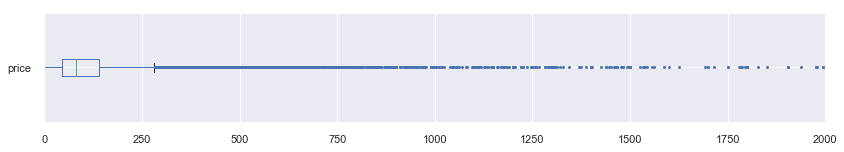

In [67]:
box_plot = dict(markerfacecolor="b", markeredgecolor="b", marker='.')
updated_data["price"].plot(kind="box", xlim=(0, 2000), vert=False, flierprops=box_plot, figsize=(14,2));

In [68]:
#Drop price values with 0 and more than 2000
updated_data.drop(updated_data[(updated_data.price > 2000) | (updated_data.price == 0) ].index, axis=0, inplace=True)

In [69]:
updated_data["price"].describe()

count    83576.000000
mean       116.666998
std        131.417579
min          6.000000
25%         45.000000
50%         81.000000
75%        139.000000
max       2000.000000
Name: price, dtype: float64

In [70]:
print("After cleaning, dataset has {} rows and {} columns.".format(*updated_data.shape))

After cleaning, dataset has 83576 rows and 21 columns.


In [71]:
updated_data.isnull().sum()

description                 1821
host_has_profile_pic           0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
bed_type                       0
amenities                      0
price                          0
cleaning_fee                   0
security_deposit               0
extra_people                   0
guests_included                0
minimum_nights                 0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
dtype: int64

=======================================================================

**Feature Engineering**

In [72]:
#Extract values from description column
updated_data.description.isna().sum()

1821

In [73]:
def distance_to_london(lat, long):
    #centroid_london = (51.509865, -0.118092)
    #accommodation = (lat, long)
    #return dist
    slat = radians(float(51.509865))
    slon = radians(float(-0.118092))
    elat = radians(float(lat))
    elon = radians(float(long))
    dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
    return dist

In [74]:
#Add distance column to the dataset
updated_data["distance_km"] = updated_data.apply(lambda x: distance_to_london(x.latitude, x.longitude), axis=1)

In [75]:
updated_data.head(2)

,description,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,distance_km
id,,,,,,,,,,,,,,,,,,,,,
13913,My bright double bedroom with a large window h...,t,Islington,51.56802,-0.11121,Apartment,Private room,2,1.0,1.0,...,65.0,15.0,100.0,15.0,1,1,f,f,moderate,6.484044
15400,Lots of windows and light. St Luke's Gardens ...,t,Kensington and Chelsea,51.48796,-0.16898,Apartment,Entire home/apt,2,1.0,1.0,...,100.0,50.0,150.0,0.0,2,3,f,f,strict_14_with_grace_period,4.282680


In [76]:
#Extract numbers from the description available
updated_data["size"] = updated_data["description"].str.extract('(\d{2,3}\s?[smSM])', expand=True)
updated_data["size"] = updated_data["size"].str.replace("\D", "")

#Change datatype of size into float
updated_data["size"] = updated_data["size"].astype(float)

In [77]:
#Taking sublist which are required for predicting size
sub_list = updated_data[["accommodates", "bathrooms", "bedrooms", "distance_km", "price", "cleaning_fee", 
                 "security_deposit", "extra_people", "guests_included", "size"]]

In [78]:
#Drop description column as it has nothing to do with the analysis now
updated_data.drop(["description"], axis=1, inplace=True)

In [79]:
#Defining training and testing dataset
train_for_size = sub_list[sub_list["size"].notnull()]
test_for_size = sub_list[sub_list["size"].isnull()]

#Drop size from the training datasets
X_train_for_size = train_for_size.drop("size", axis=1)
X_test_for_size = test_for_size.drop("size", axis=1)

y_train_for_size = train_for_size["size"]

In [80]:
#LR model to fit and test the model
lin_reg = LinearRegression()

#Fit model to training data
lin_reg.fit(X_train_for_size, y_train_for_size)

#Predicting size using LR
y_test_for_size = lin_reg.predict(X_test_for_size)

In [81]:
#Now cast a new column size with predicted values
y_test_for_size = pd.DataFrame(y_test_for_size)
y_test_for_size.columns = ["size"]
y_test_for_size.head()

(46670, 1)


,size
0,41.254377
1,47.897248
2,84.446508
3,60.473876
4,55.063539


In [82]:
updated_data[["size"]].head(10)

,size
id,
13913,NaN
15400,NaN
17402,NaN
24328,NaN
25023,10.0
25123,15.0
26223,NaN
26482,NaN
31361,NaN


In [83]:
#Test against the newly created test dataset to remove all the NaN values
X_dataframe = pd.DataFrame(X_test_for_size.index)
X_dataframe.columns = ["X_dataframe"]

#Concat the newly created X test dataset with Y dataset
y_test_for_size = pd.concat([y_test_for_size, X_dataframe], axis=1)
y_test_for_size.set_index(["X_dataframe"], inplace=True)
y_test_for_size.head()

,size
X_dataframe,
13913,41.254377
15400,47.897248
17402,84.446508
24328,60.473876
26223,55.063539


In [84]:
#Merge both X and Y test datasets together
new_test_data = pd.concat([X_test_for_size, y_test_for_size], axis=1)
new_test_data.head()

,accommodates,bathrooms,bedrooms,distance_km,price,cleaning_fee,security_deposit,extra_people,guests_included,size
13913,2,1.0,1.0,6.484044,65.0,15.0,100.0,15.0,1,41.254377
15400,2,1.0,1.0,4.282680,100.0,50.0,150.0,0.0,2,47.897248
17402,6,2.0,3.0,1.957013,300.0,65.0,350.0,10.0,4,84.446508
24328,2,1.5,1.0,5.178655,175.0,70.0,250.0,0.0,2,60.473876
26223,4,1.0,1.0,3.707254,147.0,75.0,100.0,15.0,3,55.063539


In [85]:
new_test_data["size"].isna().sum()

0

In [86]:
#Combine train and test data back to a new sub-list
sub_list_new = pd.concat([new_test_data, train_for_size], axis=0)

print(sub_list_new.shape)
sub_list_new.head()

(83576, 10)


,accommodates,bathrooms,bedrooms,distance_km,price,cleaning_fee,security_deposit,extra_people,guests_included,size
13913,2,1.0,1.0,6.484044,65.0,15.0,100.0,15.0,1,41.254377
15400,2,1.0,1.0,4.282680,100.0,50.0,150.0,0.0,2,47.897248
17402,6,2.0,3.0,1.957013,300.0,65.0,350.0,10.0,4,84.446508
24328,2,1.5,1.0,5.178655,175.0,70.0,250.0,0.0,2,60.473876
26223,4,1.0,1.0,3.707254,147.0,75.0,100.0,15.0,3,55.063539


In [87]:
#To avoid repetation/wrong value updation drop the sublist from the original list
updated_data.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance_km', 'size'], 
            axis=1, inplace=True)

In [88]:
#Merge the new sub-list and updated-data together now
new_updated_data = pd.concat([sub_list_new, updated_data], axis=1)

print(new_updated_data.shape)
new_updated_data.head(2)

(83576, 22)


,accommodates,bathrooms,bedrooms,distance_km,price,cleaning_fee,security_deposit,extra_people,guests_included,size,...,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
13913,2,1.0,1.0,6.484044,65.0,15.0,100.0,15.0,1,41.254377,...,51.56802,-0.11121,Apartment,Private room,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",1,f,f,moderate
15400,2,1.0,1.0,4.282680,100.0,50.0,150.0,0.0,2,47.897248,...,51.48796,-0.16898,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",3,f,f,strict_14_with_grace_period


In [89]:
new_updated_data["size"].isna().sum() #Just to make sure that size is copied and everything is normal again

0

In [90]:
new_updated_data["size"].describe()

count    83576.000000
mean        47.434647
std         88.050150
min          0.000000
25%         15.000000
50%         34.933928
75%         49.255665
max        995.000000
Name: size, dtype: float64

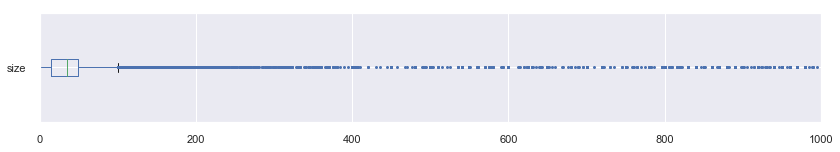

In [96]:
#Boxplot for variable sizes of rooms available in the dataset
box_plot2 = dict(markerfacecolor='b', markeredgecolor='b', marker='.')
new_updated_data["size"].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=box_plot2, figsize=(14,2));

In [97]:
print("The new dataset now has {} rows and {} columns: ".format(*new_updated_data.shape))

The new dataset now has 83576 rows and 22 columns: 


In [98]:
#Find most common 40 amenity that are available in every Airbnb
count_results = Counter()
new_updated_data["amenities"].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(count_results.update)

count_results.most_common(30)

[('Wifi', 80408),
 ('Heating', 78451),
 ('Essentials', 77730),
 ('Kitchen', 76490),
 ('Smoke detector', 71209),
 ('Washer', 71081),
 ('Hangers', 65848),
 ('Iron', 63151),
 ('Hair dryer', 57711),
 ('TV', 57560),
 ('Shampoo', 57130),
 ('Laptop friendly workspace', 52206),
 ('Carbon monoxide detector', 47790),
 ('Hot water', 43141),
 ('Dryer', 37288),
 ('Refrigerator', 28547),
 ('Bed linens', 27261),
 ('Oven', 26848),
 ('Family/kid friendly', 26050),
 ('Fire extinguisher', 26030),
 ('First aid kit', 25825),
 ('Dishes and silverware', 25461),
 ('Microwave', 24294),
 ('Cooking basics', 23961),
 ('Stove', 23262),
 ('Internet', 20655),
 ('Lock on bedroom door', 19318),
 ('Elevator', 19280),
 ('Private entrance', 18289),
 ('Long term stays allowed', 17641)]

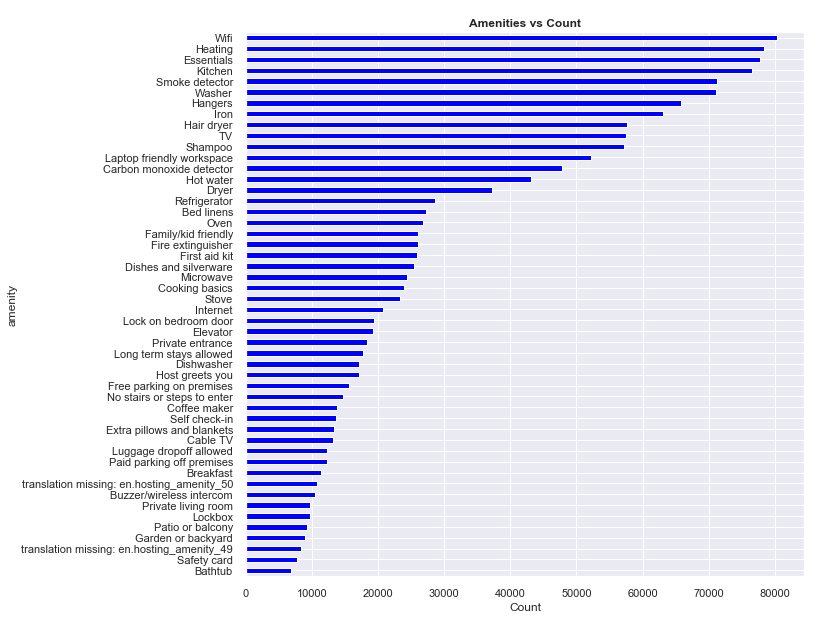

In [101]:
#Create a sublist for amenities count and plot the amenities available in different properties
amenities_count = pd.DataFrame(count_results.most_common(50), columns=["amenity", "count"])
amenities_count.sort_values(by=["count"], ascending=True).plot(kind="barh", x="amenity", y="count",  
                                                      figsize=(10,10), legend=False, color="blue")
plt.title("\nAmenities vs Count", fontsize=12, fontweight="bold");
plt.xlabel("Count");

In [102]:
#Add the above 4 amenity column separately to the dataset and reove the amenity column
new_updated_data["Laptop_friendly"] = new_updated_data["amenities"].str.contains("Laptop friendly workspace")
new_updated_data["Cable_TV"] = new_updated_data["amenities"].str.contains("TV")
new_updated_data["Kids_friendly"] = new_updated_data["amenities"].str.contains("Family/kid friendly")
new_updated_data["Host_greets"] = new_updated_data["amenities"].str.contains("Host greets you")

In [103]:
new_updated_data.drop(['amenities'], axis=1, inplace=True)

=======================================================================

**Exploratory Data Analysis**

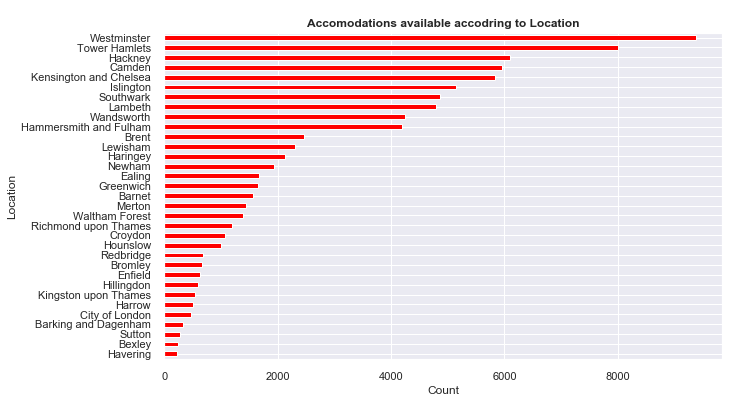

In [104]:
new_updated_data["neighbourhood_cleansed"].value_counts().sort_values().plot(kind="barh", color="red", figsize=(10,6))
plt.xlabel("Count", fontsize=12)
plt.ylabel("Location", fontsize=12)
plt.title("\nAccomodations available accodring to Location", fontsize=12, fontweight="bold");

In [ ]:
2. Price difference based on the number of accommodates

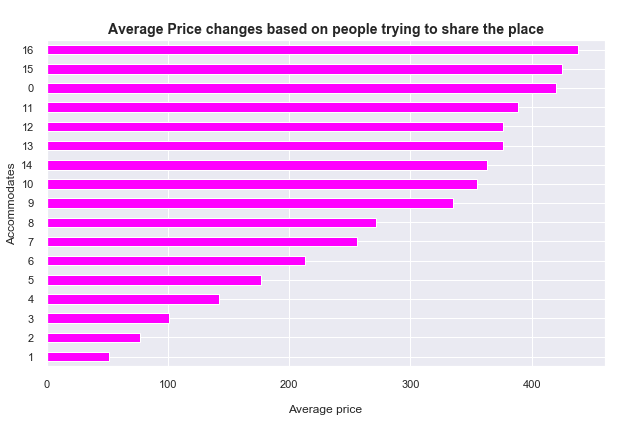

In [105]:
acc_group = pd.DataFrame(new_updated_data.groupby(["accommodates"])["price"].agg(np.average))
acc_group.reset_index(inplace=True)

acc_group.sort_values(by=["price"], ascending=True).plot(kind="barh", x="accommodates", y="price", 
                figsize=(10,6), legend=False, color="magenta")

plt.xlabel("\nAverage price", fontsize=12)
plt.ylabel("Accommodates", fontsize=12)
plt.title("\nAverage Price changes based on people trying to share the place", fontsize=14, fontweight="bold");

In [ ]:
3. Price Difference based on Location

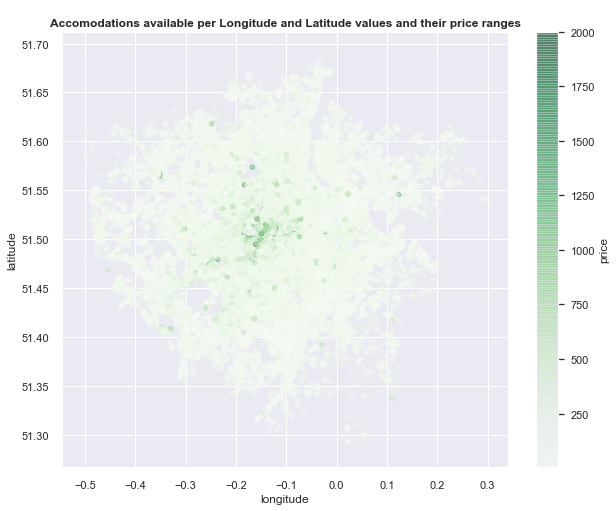

In [106]:
new_updated_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,8), c="price", cmap="Greens", 
                      colorbar=True, sharex=False);
plt.title("\nAccomodations available per Longitude and Latitude values and their price ranges", fontsize=12, fontweight="bold");

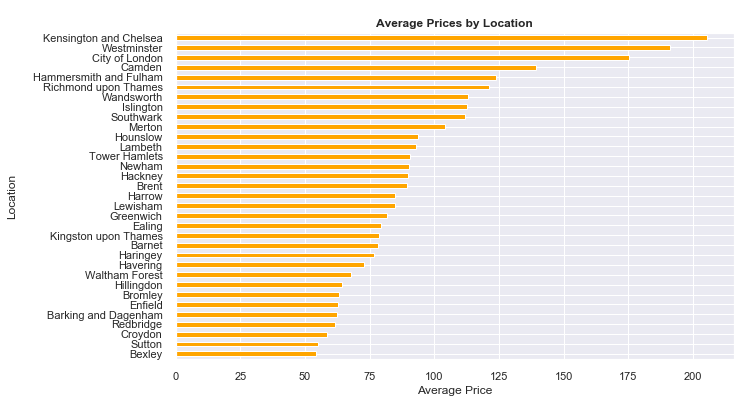

In [107]:
#Group the locations and plot them as per price in descending order
loc_group = pd.DataFrame(new_updated_data.groupby(["neighbourhood_cleansed"])["price"].agg(np.average))
loc_group.reset_index(inplace=True)

loc_group.sort_values(by=["price"], ascending=True).plot(kind="barh", x="neighbourhood_cleansed", y="price", 
                figsize=(10,6), legend=False, color="orange")

plt.xlabel("Average Price", fontsize=12)
plt.ylabel("Location\n", fontsize=12)
plt.title("\nAverage Prices by Location", fontsize=12, fontweight="bold");

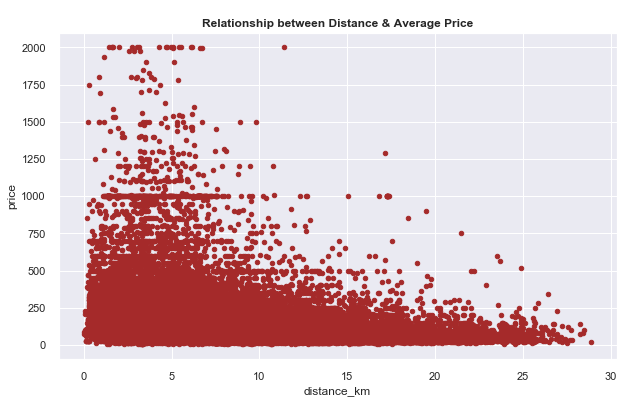

In [108]:
new_updated_data.plot.scatter(x="distance_km", y="price", figsize=(10,6), c="brown")
plt.title("\nRelationship between Distance & Average Price", fontsize=12, fontweight="bold");

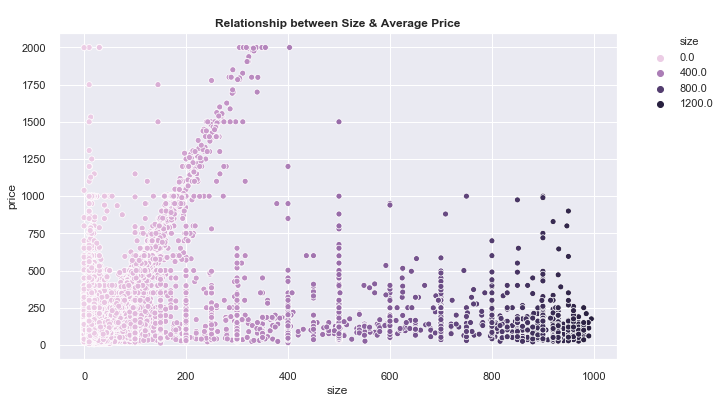

In [73]:
#Plot the chart based on size and average price
size_chart = sns.cubehelix_palette(rot=.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.scatterplot(x="size", y="price", sizes=(5, 200), hue="size", palette=size_chart,  data=new_updated_data)

plt.title("\nRelationship between Size & Average Price", fontsize=12, fontweight="bold")

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

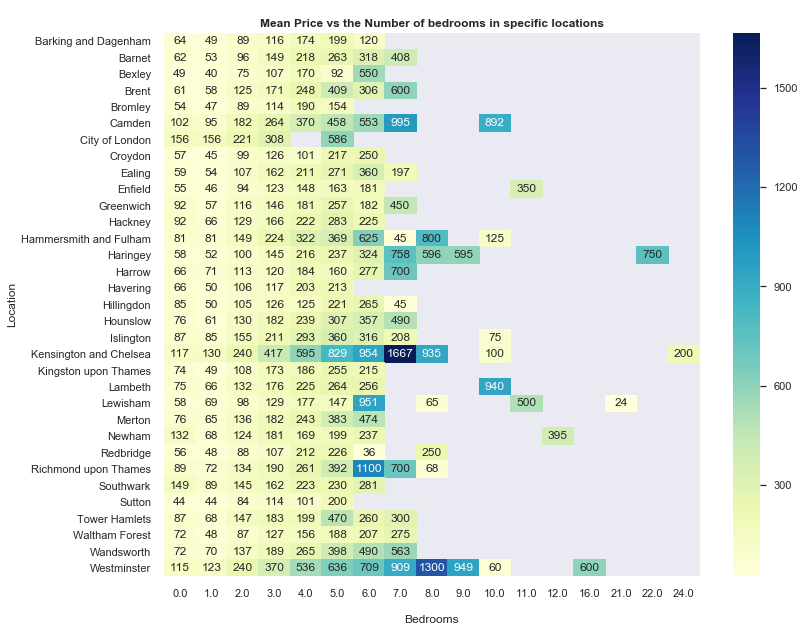

In [109]:
plt.figure(figsize=(12,10))
sns.heatmap(new_updated_data.groupby(["neighbourhood_cleansed", "bedrooms"]).price.mean().unstack(), cmap='YlGnBu', annot=True, fmt=".0f")

plt.xlabel("\nBedrooms", fontsize=12)
plt.ylabel("Location", fontsize=12)
plt.title("\nMean Price vs the Number of bedrooms in specific locations", fontsize=12, fontweight="bold");

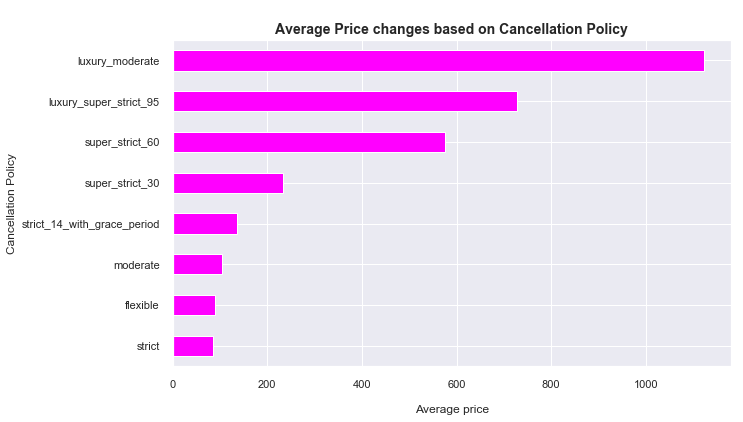

In [110]:
can_group = pd.DataFrame(new_updated_data.groupby(["cancellation_policy"])["price"].agg(np.average))
can_group.reset_index(inplace=True)

can_group.sort_values(by=["price"], ascending=True).plot(kind="barh", x="cancellation_policy", y="price", 
                figsize=(10,6), legend=False, color="magenta")

plt.xlabel("\nAverage price", fontsize=12)
plt.ylabel("Cancellation Policy", fontsize=12)
plt.title("\nAverage Price changes based on Cancellation Policy", fontsize=14, fontweight="bold");

=======================================================================

**Modelling of Data**

In [111]:
new_updated_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83576 entries, 13913 to 36585818
Data columns (total 26 columns):
accommodates                83576 non-null int64
bathrooms                   83576 non-null float64
bedrooms                    83576 non-null float64
distance_km                 83576 non-null float64
price                       83576 non-null float64
cleaning_fee                83576 non-null float64
security_deposit            83576 non-null float64
extra_people                83576 non-null float64
guests_included             83576 non-null int64
size                        83576 non-null float64
host_has_profile_pic        83576 non-null object
neighbourhood_cleansed      83576 non-null object
latitude                    83576 non-null float64
longitude                   83576 non-null float64
property_type               83576 non-null object
room_type                   83576 non-null object
bed_type                    83576 non-null object
minimum_nights            

In [113]:
new_updated_data.drop(["latitude", "longitude", "neighbourhood_cleansed", "property_type"], axis=1, inplace=True)

In [115]:
#Convert string based columns to category
for col in ["host_has_profile_pic", "room_type", "bed_type", "instant_bookable", 
            "is_business_travel_ready", "cancellation_policy"]:
    new_updated_data[col] = new_updated_data[col].astype("category")

In [116]:
#Remove price from the dataset, as we are going to predict the price values based on other features
remove_price = new_updated_data[["price"]]
reqd_dataset = new_updated_data.drop(["price"], axis=1)

In [117]:
feature_1 = reqd_dataset.select_dtypes(include=['float64', 'int64', 'bool']).copy()
feature_2 = reqd_dataset.select_dtypes(include=['category']).copy()

#category column will have 1 for "t" and 0 for others
dumm_feature_2 = pd.get_dummies(feature_2)

In [118]:
#Now concat the two types of features together
features = pd.concat([feature_1, dumm_feature_2], axis=1)

In [119]:
features.head(2)

,accommodates,bathrooms,bedrooms,distance_km,cleaning_fee,security_deposit,extra_people,guests_included,size,minimum_nights,...,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_luxury_moderate,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
13913,2,1.0,1.0,6.484044,15.0,100.0,15.0,1,41.254377,1,...,0,1,0,0,0,1,0,0,0,0
15400,2,1.0,1.0,4.282680,50.0,150.0,0.0,2,47.897248,3,...,0,1,0,0,0,0,0,1,0,0


In [120]:
#Split dataset based on independent variable "features" and dependent variable "price"
X_train, X_test, y_train, y_test = train_test_split(features, remove_price, test_size=0.2)

In [121]:
#Scale the data based on the StandardScaler function
std_sc = StandardScaler()
X_train = std_sc.fit_transform(X_train)
X_test  = std_sc.transform(X_test)

C:\Users\Akhil Harry\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Akhil Harry\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Akhil Harry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [118]:
#To find out the best parameters for the XGB booster
#Run only if required. Laptop was taking so much time and hence took an assumption instead
'''
parameters = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

#Train the random forest
booster_grid_search.fit(X_train, y_train)

#Print the best parameter values
print(booster_grid_search.best_params_)
'''

In [122]:
#Instantiate xgboost with best parameters - assumption
model_param = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, 
                           max_depth=6, n_estimators=200, random_state=4)

#Train the model with best parameters of XGB
model_param.fit(X_train, y_train)

#Test and predict the prices
y_pred_train = model_param.predict(X_train)
y_pred_test = model_param.predict(X_test)

[00:58:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [123]:
y_pred_test

array([ 83.42225 ,  48.537422, 167.14114 , ...,  35.89325 ,  98.303825,
        37.558273], dtype=float32)

In [124]:
#The root means sqaure error value calculation
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
RMSE

56.050351229496066

In [125]:
#The r2 (R^2) values calculation
r2 = r2_score(y_test, y_pred_test)
r2

0.807036120312451

Text(0.5, 1.0, '\nImportant features to predict price based on the XGB Regressor modelling')

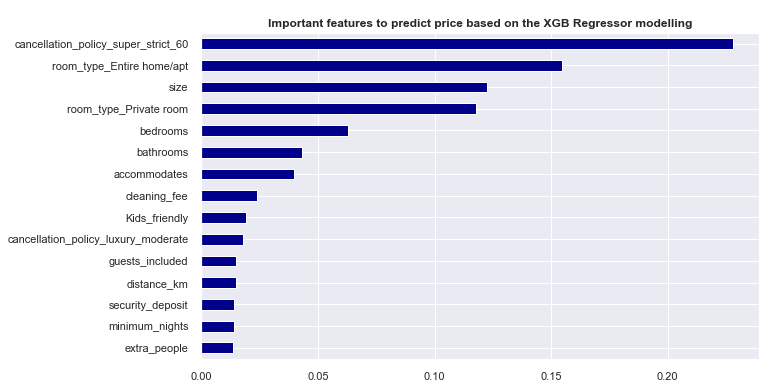

In [129]:
#Plot the crucial features based on the model
imp_feature = pd.Series(model_param.feature_importances_, index=features.columns)
imp_feature.nlargest(15).sort_values().plot(kind="barh", color="darkblue", figsize=(10,6))
plt.title("\nImportant features to predict price based on the XGB Regressor modelling", fontsize=12, fontweight="bold")

**Interpretation:**

From the analysis it can be seen that Price value not just depends upon the location, room_type or size but also gets influenced by a lot of other features like:

1. The quality of pictures, profile pics, etc)
2. Availability of homes
3. The number and content of reviews, reviews
4. Acceptance rate, host response time, etc
5. Host type (super or normal)
6. And rest few

These features may not have much impact but might have a substantial influence. 

This analysis focuses on providing a price range for a new person to look on Airbnb and identify the price ranges based on the features provided.

At the moment the r2 value is not so efficient which can be improved by including the above mentioned features too with the ones modelling has been done on. This can possibly give a better result.

Run the parameters values to find the best parameter of XGBRegressor.

Also, a k-fold cross verification can be performed to improve the error and also to clarify the training and test dataset in future.